# UCI Heart Disease

Author: Darshan Sundaram


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import  KFold,GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, make_scorer, log_loss, roc_curve, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline
import math

I start off by installing all the required packages. I will be using pandas to wrangle the two data sets. Several built in functions in sklearn and mlxtend will assist me in developing and optimizing this SVM model. I will cycle through most of the applicable kernels and their parameters to find the optimized parameter set.

## Groundwork

I load the training and test datasets, and wrangle the independent and dependent variables into their own array. 

In [2]:

dataset = pd.read_csv('hearttrain.csv')
dataset2 = pd.read_csv('heartval.csv') 
dataset3 = pd.read_csv('hearttest.csv')
    
dataset.head(10)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,255,71.0,0.0,2.0,160.0,302.0,0.0,0.0,162.0,0.0,0.4,1.0,2.0,3.0,1
1,204,55.0,1.0,4.0,160.0,289.0,0.0,2.0,145.0,1.0,0.8,2.0,1.0,7.0,2
2,267,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,1
3,92,54.0,1.0,4.0,124.0,266.0,0.0,2.0,109.0,1.0,2.2,2.0,1.0,7.0,2
4,149,41.0,0.0,3.0,112.0,268.0,0.0,2.0,172.0,1.0,0.0,1.0,0.0,3.0,1
5,111,41.0,1.0,2.0,110.0,235.0,0.0,0.0,153.0,0.0,0.0,1.0,0.0,3.0,1
6,170,69.0,1.0,1.0,160.0,234.0,1.0,2.0,131.0,0.0,0.1,2.0,1.0,3.0,1
7,225,41.0,1.0,2.0,135.0,203.0,0.0,0.0,132.0,0.0,0.0,2.0,0.0,6.0,1
8,100,44.0,0.0,3.0,108.0,141.0,0.0,0.0,175.0,0.0,0.6,2.0,0.0,3.0,1
9,145,53.0,1.0,4.0,123.0,282.0,0.0,0.0,95.0,1.0,2.0,2.0,2.0,7.0,2


In [3]:
train_val = dataset.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13]]
train_lab = dataset.iloc[:,14]

val_val = dataset2.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13]]
val_lab = dataset2.iloc[:,14]

test_val = dataset3.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13]]
test_lab = dataset3.iloc[:,14]

cv = pd.concat([dataset,dataset2])
cv_val = cv.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13]]
cv_lab = cv.iloc[:,14]


# Simple Model

In [4]:
accf = []
specf=[]
sensf=[]
f1f = []

GB = GaussianNB()

GB.fit(train_val,train_lab)
#validation
predict = GB.predict(val_val)
confusion = confusion_matrix(val_lab,predict)
acc = accuracy_score(val_lab, predict)
f1 = f1_score(val_lab,predict)
TN, FP    = confusion[0, 0], confusion[0, 1]
FN, TP    = confusion[1, 0], confusion[1, 1]
spec = round(TN / float(TN + FP),3)*100
sens = round(TP / float(TP + FN),3)*100
accf.append(acc)
f1f.append(f1)
specf.append(spec)
sensf.append(sens)
#training
predict1 = GB.predict(train_val)
confusion1 = confusion_matrix(train_lab,predict1)
acc1 = accuracy_score(train_lab, predict1)
f11 = f1_score(train_lab,predict1)
TN1, FP1   = confusion1[0, 0], confusion1[0, 1]
FN1, TP1    = confusion1[1, 0], confusion1[1, 1]
spec1 = round(TN1 / float(TN1 + FP1),3)*100
sens1 = round(TP1 / float(TP1 + FN1),3)*100
accf.append(acc1)
f1f.append(f11)
specf.append(spec1)
sensf.append(sens1)


In [5]:
dic = {'accuracy': accf, 'F1': f1f, "Specificity": specf, "Sensitivity": sensf}
pd.DataFrame(dic, index = ['Validation', 'Training'])

,accuracy,F1,Specificity,Sensitivity
Validation,0.750000,0.744186,66.7,85.0
Training,0.872093,0.887755,89.7,84.0


In the case of predicting heart disease, in my opinion, the most important of the parameters at hand are F1 and Sensitivity. Although accuracy and specificity as still valuable, they are less so in this case. Accuracy for one, can be affected by imbalanced datasets whereas F1 offers a harmonic mean of precision and recall. Sensitivity is the ability to identify individuals who has the heart disease accuractely. Specificity is the ability to identify individuals who dont have the heart disease accurately. In cases like medical diagnosis, error in diagnosis, where cases of heart disease are incorrectly labelled as no heart disease can be very damaging. The capture of sensitivity, controls for false negatives. Henceforth, F1 and sensitivity will be the two metrics I look for first. 

Here, using a Gaussian Naive Bayes classifier (great for binary problems), we get an F1 score of 74.4% and a Sensitivity of 85%. The accuracy is 75% and specificity is 66.7%. We have a respectable F1 score, and capture a fairly high percent of our positives. The training values will be higher across the board, as we trained our model on the training data, our model will perform better on it, as we see. 

# Gradient Descent 

I will first try to simply train on the training set and predict on the validation set. Using those prediction I will find the required scores. Additionally I will be using Robust Scaler to scale my data as after visual inspection I found a few outliers within the feature set, however any other scaler (MinMax/ StandardScaler) could also have been used. 

In [6]:
accuracy_1 = []
f1_1 = []
sens_1 = []
spec_1 = []
for al in (1e-17,0.001, 0.01,0.1,1):
    model1 = [("Robust",RobustScaler()),('SVM',SGDClassifier(loss = 'log',penalty = "l2",alpha = al))]
    model = Pipeline(model1)
    model.fit(train_val,train_lab)
    predict = model.predict(val_val)
    confusion = confusion_matrix(val_lab,predict)
    acc = accuracy_score(val_lab, predict)
    f1 = f1_score(val_lab,predict)
    TN, FP    = confusion[0, 0], confusion[0, 1]
    FN, TP    = confusion[1, 0], confusion[1, 1]
    spec = round(TN / float(TN + FP),3)*100
    sens = round(TP / float(TP + FN),3)*100
    accuracy_1.append(acc)
    f1_1.append(f1)
    spec_1.append(spec)
    sens_1.append(sens)
    


In [7]:
dic1 = {'accuracy': accuracy_1, 'F1': f1_1, "Specificity": spec_1, "Sensitivity": sens_1}
pd.DataFrame(dic1, index = ['1e-17','0.001','0.01','0.1','1'])

,accuracy,F1,Specificity,Sensitivity
1e-17,0.772727,0.800000,83.3,70.0
0.001,0.659091,0.651163,58.3,75.0
0.01,0.795455,0.808511,79.2,80.0
0.1,0.795455,0.816327,83.3,75.0
1,0.772727,0.800000,83.3,70.0


I am not happy with the reliability of these measures and I want a bigger dataset to find my scores on, as a result I have combined my training and validation set into a cross validation dataset and will perform 5 fold CV next.

In [8]:
def specificity(y_true, y_pred): #custom scorers
    confusion = confusion_matrix(y_true,y_pred)
    TN, FP    = confusion[0, 0], confusion[0, 1]
    FN, TP    = confusion[1, 0], confusion[1, 1]
    spec = round(TN / float(TN + FP),3)*100
    return spec
def sensitivity(y_true, y_pred):
    confusion = confusion_matrix(y_true,y_pred)
    TN, FP    = confusion[0, 0], confusion[0, 1]
    FN, TP    = confusion[1, 0], confusion[1, 1]
    sens = round(TP / float(TP + FN),3)*100
    return sens

In [9]:
model1 = [("Standard",RobustScaler()),
              ('SGD',SGDClassifier(loss = 'log',penalty = "l2", random_state =45))]
model = Pipeline(model1)
scoring = {'F1': 'f1', 'Accuracy': 'accuracy', 'Sensitivity': make_scorer(sensitivity), 'Specificity': make_scorer(specificity)}
param_grid1 = [{ "SGD__alpha":[1,0.1,0.01,0.001,1e-17]}]  #Parameter grid
k_fold = KFold(5, shuffle= True, random_state = 9)
grid = GridSearchCV(model,param_grid = param_grid1,cv = k_fold,scoring = scoring,verbose = 3, n_jobs = -1, refit = 'Accuracy') #GridSearch

In [10]:
grid.fit(cv_val,cv_lab)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:    6.2s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:    6.2s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.3s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=9, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('Standard', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('SGD', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate=...dom_state=45, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'SGD__alpha': [1, 0.1, 0.01, 0.001, 1e-17]}],
       pre_dispatch='2*n_jobs', refit='Accuracy',
       return_train_score='warn',
       scoring={'F1': 'f1', 'Accuracy': 'accuracy', 'Sensitivity': make_scorer(sensitivity), 'Specificity': make_scorer(specificity)},
       verbose=3)

In [11]:
grid.cv_results_


{'mean_fit_time': array([0.03011937, 0.0341084 , 0.01835165, 0.03231382, 0.01715541]),
 'std_fit_time': array([0.0174163 , 0.01251023, 0.00406832, 0.01224114, 0.00486166]),
 'mean_score_time': array([0.0069819 , 0.00638518, 0.00858006, 0.00758023, 0.00758018]),
 'std_score_time': array([0.00189203, 0.00101672, 0.00286784, 0.00119764, 0.00348921]),
 'param_SGD__alpha': masked_array(data=[1, 0.1, 0.01, 0.001, 1e-17],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'SGD__alpha': 1},
  {'SGD__alpha': 0.1},
  {'SGD__alpha': 0.01},
  {'SGD__alpha': 0.001},
  {'SGD__alpha': 1e-17}],
 'split0_test_F1': array([0.84      , 0.83333333, 0.88888889, 0.90909091, 0.8       ]),
 'split1_test_F1': array([0.84745763, 0.85245902, 0.86666667, 0.87719298, 0.86206897]),
 'split2_test_F1': array([0.88      , 0.93877551, 0.93877551, 0.85714286, 0.82758621]),
 'split3_test_F1': array([0.7027027 , 0.72222222, 0.76470588, 0.68292683, 0.7368

I see that we have a lot of output there. I will only focus on the testing set mean scores and will be save them as a dictionary so I can access them as a data frame for easy comparison.

In [12]:
dic3 = {'mean_test_F1': ([0.83911083, 0.84707189, 0.86525067, 0.83893038, 0.8147225 ]),
 'std_test_F1': ([0.07438024, 0.07189936, 0.05659758, 0.07973862, 0.04409237]),
        'mean_test_Accuracy': ([0.81944444, 0.8287037 , 0.85185185, 0.81944444, 0.79166667]),
 'std_test_Accuracy': ([0.0494955 , 0.05589019, 0.04820191, 0.06870644, 0.02181586]),

'mean_test_Sensitivity': ([67.16481481, 71.26666667, 78.51666667, 75.55138889, 70.17638889]),
 'std_test_Sensitivity': ([ 7.45525933, 11.68813897, 10.44817014, 10.19153143, 14.06429508]),


 'mean_test_Specificity': ([91.55833333, 90.22314815, 88.94907407, 87.83425926, 85.95833333]),
 'std_test_Specificity': ([6.30319033, 4.89085705, 5.50049653, 2.3383938 , 9.13623357])}
pd.DataFrame(dic3, index = ['1','0.1','0.01','0.001','1e-17'])

,mean_test_F1,std_test_F1,mean_test_Accuracy,std_test_Accuracy,mean_test_Sensitivity,std_test_Sensitivity,mean_test_Specificity,std_test_Specificity
1,0.839111,0.074380,0.819444,0.049495,67.164815,7.455259,91.558333,6.303190
0.1,0.847072,0.071899,0.828704,0.055890,71.266667,11.688139,90.223148,4.890857
0.01,0.865251,0.056598,0.851852,0.048202,78.516667,10.448170,88.949074,5.500497
0.001,0.838930,0.079739,0.819444,0.068706,75.551389,10.191531,87.834259,2.338394
1e-17,0.814723,0.044092,0.791667,0.021816,70.176389,14.064295,85.958333,9.136234


I combine the validation and the training set to create a cross-validation dataset. I use gridsearchCV to run through the different regularization parameters, and use the required scoring metric (two customized for sensitivity/specificity). As we see, we get the highest F1 score (86.5%) and the sensitivity of 78.5%. The specificity is 3rd highest (88.84% compared to 91.55% and 90.223% for alpha = 1 and 0.1 respectively). This change is marginally better and only ranks 3rd on my priority list of metrics to consider. The accuracy is also the highest for an alpha of 0.01. As a result, my ideal alpha value is 0.01. However a combination of random_state usage and scaler influence can change this alpha value. Ideally I want to have a much bigger dataset so these conflicts or subjectivity doesn't occur. 

# Error graphs for optimization

In [13]:
a = []
b = []

for i in range(0,1000,1):
    model1 = [("Robust",RobustScaler()),
              ('SVM',SGDClassifier(loss = 'log',alpha = 0.01,penalty = "l2", n_iter = i, random_state = 45))]
    model = Pipeline(model1)
    #model = SGDClassifier(loss = 'log',alpha = 0.001,penalty = "l2", n_iter = i,shuffle = True,random_state = 7)
    model.fit(train_val,train_lab)
    trainp = model.predict_proba(train_val)
    valp = model.predict_proba(val_val)
    a.append(log_loss(train_lab,trainp))
    b.append(log_loss(val_lab,valp))

In [2]:
dict = {}
dict[2] = "2edf"

In [3]:
dict

{2: '2edf'}

In [14]:
b.index(min(b)) #index of lowest log-loss at point of overfit

3

Text(0.5,1,'Val and Training log-loss minimization')

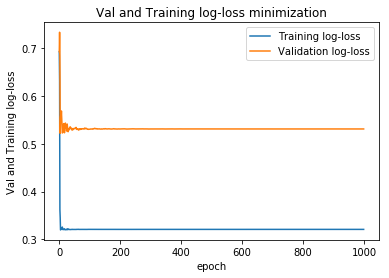

In [15]:
plt.figure()
plt.plot(range(0,1000,1),a, label = "Training log-loss")
plt.plot(range(0,1000,1),b, label = "Validation log-loss")
plt.legend(loc = 'best')
plt.xlabel("epoch")
plt.ylabel("Val and Training log-loss")
plt.title("Val and Training log-loss minimization")


## Model Selection

After using stochastic gradient descent, I came to a conclusion that the optimal alpha value is 0.01. Using that alpha value, I perform optimization through an iterative fashion. Using those results, I came to the conclusion that 3 iterations is the optimal number passes over the training data, as the log loss was minized at that pass. Using this combined model I would then use it to predict the final model. Comparing this to the Naive Bayes classifier, we have higher F1 score (86.5% VS 74.4%) and a lower sensitivity (78.5% vs 85.5%). The difference in sensitivity is quite big however I will stick to the Logistic regression model as the values are the result of  5 fold CV on a large training + validation dataset. The Naive Bayes has more variance to it as it was a one-off classification. Additionally we have a much higher specificity (88.94% vs 66.7%) and accuracy (86.5% vs 75%). The favor of 3 metrics towards the Logistic regression with SGD is enough to make me choose that as my ideal model.


In [16]:
dict_final = {"Naive Bayes": (0.750000,0.744186,66.7,85.0), "SGD": (0.865251,0.85185185,88.94907407,78.51666667)}
pd.DataFrame(dict_final, index = ['Accuracy','F1','Specificity','Sensitivity'])

,Naive Bayes,SGD
Accuracy,0.750000,0.865251
F1,0.744186,0.851852
Specificity,66.700000,88.949074
Sensitivity,85.000000,78.516667


In [17]:
model1 = [("Robust",StandardScaler()),
              ('SVM',SGDClassifier(loss = 'log',alpha = 0.1,penalty = "l2", n_iter = 3, random_state = 45))]
model = Pipeline(model1)
#model = SGDClassifier(loss = 'log',alpha = 0.001,penalty = "l2", n_iter = i,shuffle = True,random_state = 7)
model.fit(train_val,train_lab)
predict = model.predict(test_val)
confusion = confusion_matrix(test_lab,predict)
acc5 = accuracy_score(test_lab, predict)
f15 = f1_score(test_lab,predict)
TN, FP    = confusion[0, 0], confusion[0, 1]
FN, TP    = confusion[1, 0], confusion[1, 1]
spec5 = round(TN / float(TN + FP),3)*100
sens5 = round(TP / float(TP + FN),3)*100
dic = {'accuracy': acc5, 'F1': f15, "Specificity": spec5, "Sensitivity": sens5}
pd.DataFrame(dic, index = ['Testing'])

,accuracy,F1,Specificity,Sensitivity
Testing,0.907407,0.915254,93.1,88.0



I performed a test after predicting using the test dataset features and we get an F1 score of 91.5%, 88% sensitivity, 93.1% specificity and 90.7% accuracy. Pretty good values! 

## Output predicted test labels

In [18]:
dataset3["Predicted Label"] = predict #Adding 'Label' column

xport = dataset3.to_csv('hw1_testset_out_final.csv') #Exporting to .csv
dataset3.tail(10)  #sample

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Predicted Label
44,134,54.0,1.0,3.0,150.0,232.0,0.0,2.0,165.0,0.0,1.6,1.0,0.0,7.0,1,2
45,49,65.0,0.0,4.0,150.0,225.0,0.0,2.0,114.0,0.0,1.0,2.0,3.0,7.0,2,2
46,61,51.0,0.0,4.0,130.0,305.0,0.0,0.0,142.0,1.0,1.2,2.0,0.0,7.0,2,2
47,15,71.0,0.0,4.0,112.0,149.0,0.0,0.0,125.0,0.0,1.6,2.0,0.0,3.0,1,1
48,162,55.0,1.0,2.0,130.0,262.0,0.0,0.0,155.0,0.0,0.0,1.0,0.0,3.0,1,1
49,43,46.0,1.0,2.0,101.0,197.0,1.0,0.0,156.0,0.0,0.0,1.0,0.0,7.0,1,1
50,121,54.0,1.0,4.0,122.0,286.0,0.0,2.0,116.0,1.0,3.2,2.0,2.0,3.0,2,2
51,133,64.0,1.0,4.0,120.0,246.0,0.0,2.0,96.0,1.0,2.2,3.0,1.0,3.0,2,2
52,201,58.0,1.0,4.0,125.0,300.0,0.0,2.0,171.0,0.0,0.0,1.0,2.0,7.0,2,2
53,171,69.0,1.0,3.0,140.0,254.0,0.0,2.0,146.0,0.0,2.0,2.0,3.0,7.0,2,2
